# Forecasting Credit Ratings of Corporations

### Introduction

The objective of this project is to leverage data analysis techniques to extract meaningful insights and forecast credit ratings for corporations. Utilizing a curated dataset sourced from Kaggle, the project aims to preprocess the data meticulously before feeding it into diverse machine learning models for predictive analysis. Subsequently, the models will undergo optimization and thorough evaluation to ensure their accuracy and reliability in predicting credit ratings.


### Data Preparation

In [120]:
# Import Dependencies 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from pyspark.sql.functions import col
import re
import numpy as np


To initiate the project, the first steps involve creating a Spark Session to harness the power of distributed computing and loading the dataset into a Spark DataFrame. This DataFrame will serve as the foundation for exploring the data in-depth and extracting valuable insights.

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/03/20 10:16:31 WARN Utils: Your hostname, Home-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en1)
24/03/20 10:16:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 10:16:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the CSV into a DataFrame.
from pyspark import SparkFiles
path = "../data/ratings.csv"

spark.sparkContext.addFile(path)
df = spark.read.csv(SparkFiles.get("ratings.csv"), sep=",", header=True)
df.show()

+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+------------------------+-----------------+------------+----------------+-----------+-------------+---------------------+-----------------+--------------+----------------------+-------------------------+----------------------+--------------------------+-----------------------------+------------------------+
|       Rating Agency|         Corporation|Rating|Rating Date|    CIK|Binary Rating|SIC Code|Sector|Ticker|Current Ratio|Long-term Debt / Capital|Debt/Equity Ratio|Gross Margin|Operating Margin|EBIT Margin|EBITDA Margin|Pre-Tax Profit Margin|Net Profit Margin|Asset Turnover|ROE - Return On Equity|Return On Tangible Equity|ROA - Return On Assets|ROI - Return On Investment|Operating Cash Flow Per Share|Free Cash Flow Per Share|
+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+-------------------

In [4]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView('ratings')

In [19]:
# View the Schema
df.printSchema()

root
 |-- Rating Agency: string (nullable = true)
 |-- Corporation: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Date: string (nullable = true)
 |-- CIK: string (nullable = true)
 |-- Binary Rating: string (nullable = true)
 |-- SIC Code: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Current Ratio: string (nullable = true)
 |-- Long-term Debt / Capital: string (nullable = true)
 |-- Debt/Equity Ratio: string (nullable = true)
 |-- Gross Margin: string (nullable = true)
 |-- Operating Margin: string (nullable = true)
 |-- EBIT Margin: string (nullable = true)
 |-- EBITDA Margin: string (nullable = true)
 |-- Pre-Tax Profit Margin: string (nullable = true)
 |-- Net Profit Margin: string (nullable = true)
 |-- Asset Turnover: string (nullable = true)
 |-- ROE - Return On Equity: string (nullable = true)
 |-- Return On Tangible Equity: string (nullable = true)
 |-- ROA - Return On Assets: string (null

In [28]:
query = """
SELECT COUNT(DISTINCT Corporation) AS DistinctCorporationsCount
FROM ratings
"""
spark.sql(query).show()  


+-------------------------+
|DistinctCorporationsCount|
+-------------------------+
|                     1377|
+-------------------------+



In [29]:
query = """
SELECT Corporation, COUNT(*) as Frequency
FROM ratings
GROUP BY Corporation
ORDER BY Frequency DESC
LIMIT 5
"""
spark.sql(query).show()


+--------------------+---------+
|         Corporation|Frequency|
+--------------------+---------+
|      TransDigm Inc.|       23|
|Mondelez Internat...|       23|
|Tenet Healthcare ...|       23|
|Duke Energy Corpo...|       22|
|               POSCO|       21|
+--------------------+---------+



In [33]:
query = """
SELECT `Rating Agency`, COUNT(*) AS AgencyCount
FROM ratings
GROUP BY `Rating Agency`
ORDER BY AgencyCount DESC
"""
spark.sql(query).show()


+--------------------+-----------+
|       Rating Agency|AgencyCount|
+--------------------+-----------+
|Egan-Jones Rating...|       2826|
|Standard & Poor's...|       2813|
|Moody's Investors...|       1636|
|       Fitch Ratings|        477|
|                DBRS|         26|
|Japan Credit Rati...|         22|
|HR Ratings de Mex...|          5|
+--------------------+-----------+



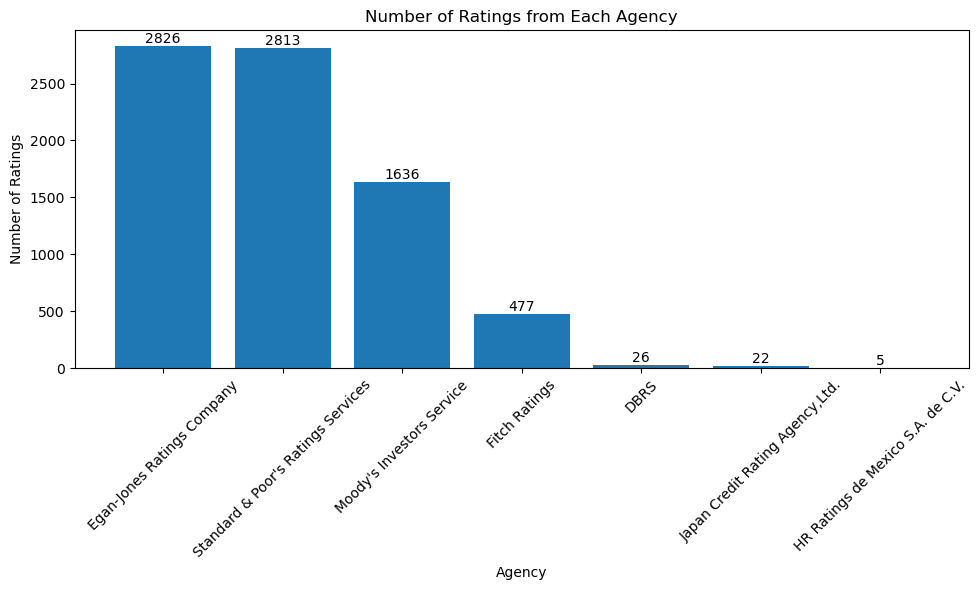

In [35]:
# Chart the count for rating agencies, storing the temporary results in a Pandas DF
result_df = spark.sql(query).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(result_df['Rating Agency'], result_df['AgencyCount'])
plt.title('Number of Ratings from Each Agency')
plt.xlabel('Agency')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/agency_count.png')
plt.show()




In [7]:
# Query the dataset to count the number of each rating

query = """
SELECT Rating, COUNT(*) as RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating ASC
"""
spark.sql(query).show(100)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



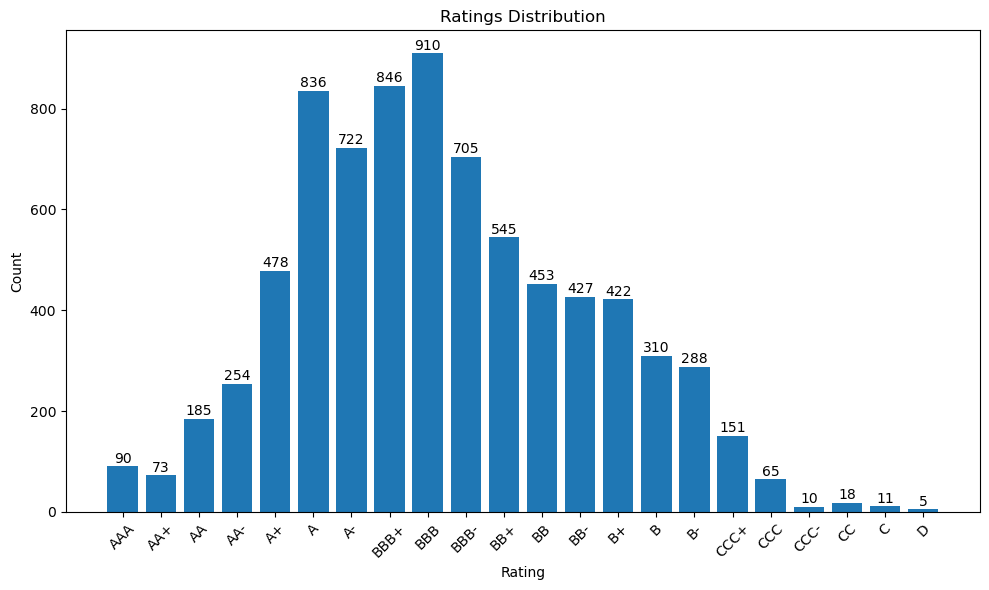

In [41]:
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating;
"""
result_df = spark.sql(query).toPandas()

result_df['RatingCount'] = pd.to_numeric(result_df['RatingCount'], errors='coerce').fillna(0).astype(int)

# Sort 
sorted_df = result_df.copy()
sorted_df['Rating'] = sorted_df['Rating'].astype(str)
sorted_df['Rating'] = pd.Categorical(sorted_df['Rating'], categories=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D'], ordered=True)
sorted_df = sorted_df.sort_values('Rating')
sorted_df = sorted_df.dropna(subset=['Rating'])

x_labels = sorted_df['Rating'].astype(str)
y_values = sorted_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Distribution')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings.png')
plt.show()


In [5]:
# Explore the data
query = """
SELECT YEAR(`Rating Date`) as YEAR, Rating, COUNT(Rating)
FROM ratings
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY YEAR(`Rating Date`), COUNT(Rating) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Rating|count(Rating)|
+----+------+-------------+
|2010|  BBB+|            6|
|2010|   BBB|            5|
|2010|    A-|            5|
|2010|  BBB-|            5|
|2010|     A|            5|
|2010|   AAA|            3|
|2010|   BB+|            3|
|2010|   BB-|            3|
|2010|    B+|            2|
|2010|    BB|            2|
|2010|   AA-|            1|
|2010|     B|            1|
|2011|   BBB|           41|
|2011|     A|           40|
|2011|  BBB-|           36|
|2011|  BBB+|           36|
|2011|   BB-|           23|
|2011|     B|           23|
|2011|    A-|           22|
|2011|   BB+|           22|
|2011|    BB|           16|
|2011|    A+|           10|
|2011|    AA|           10|
|2011|   AAA|           10|
|2011|  CCC+|            9|
|2011|    B+|            9|
|2011|    B-|            6|
|2011|   CCC|            6|
|2011|   AA-|            3|
|2011|    CC|            1|
|2011|     C|            1|
|2011|  CCC-|            1|
|2012|   BBB|       

In [45]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, COUNT(Rating) as RatingCount
FROM ratings
GROUP BY YEAR(`Rating Date`) 
ORDER BY YEAR(`Rating Date`), RatingCount DESC;
"""
spark.sql(query).show()

+----+-----------+
|YEAR|RatingCount|
+----+-----------+
|2010|         41|
|2011|        325|
|2012|       1071|
|2013|       1387|
|2014|       1944|
|2015|       2062|
|2016|        975|
+----+-----------+



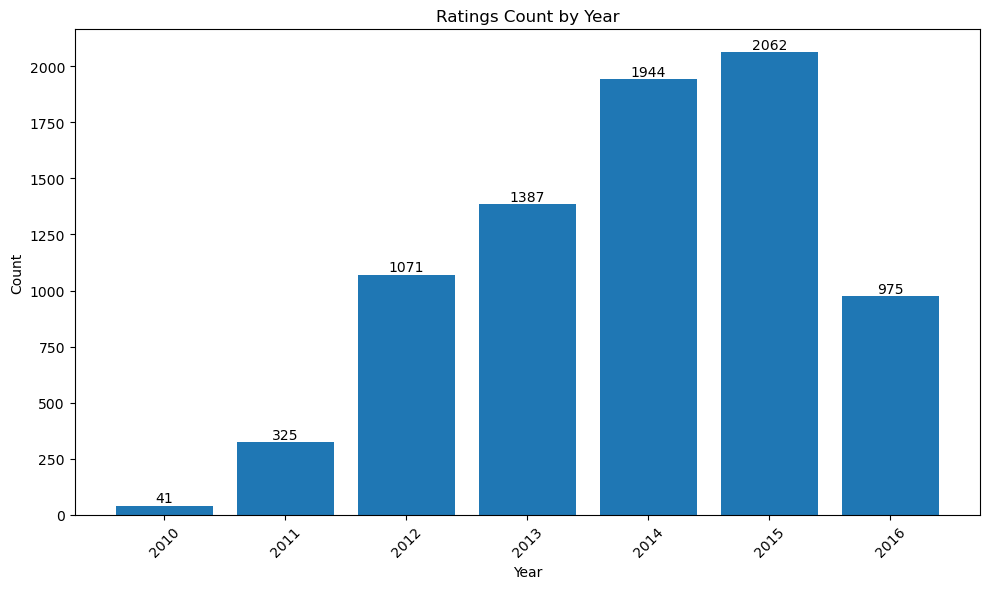

In [49]:
result_df = spark.sql(query).toPandas()

x_labels = result_df['YEAR']
y_values = result_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Ratings Count by Year')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings_by_Year.png')
plt.show()


In [51]:
query = """
SELECT Sector, COUNT(Rating) as RatingCount
FROM ratings
GROUP BY Sector 
ORDER BY RatingCount DESC;
"""
spark.sql(query).show()

+------+-----------+
|Sector|RatingCount|
+------+-----------+
| Other|       1251|
| Manuf|        981|
| BusEq|        958|
| Utils|        843|
| Shops|        786|
| Enrgy|        665|
|  Hlth|        625|
| NoDur|        567|
| Telcm|        386|
| Chems|        315|
| Durbl|        221|
| Money|        207|
+------+-----------+



In [61]:
query = """
SELECT `Binary Rating` AS Binary_Ratings, COUNT(*) AS Count
FROM ratings
GROUP BY `Binary Rating`
"""
spark.sql(query).show()

+--------------+-----+
|Binary_Ratings|Count|
+--------------+-----+
|             0| 2706|
|             1| 5099|
+--------------+-----+



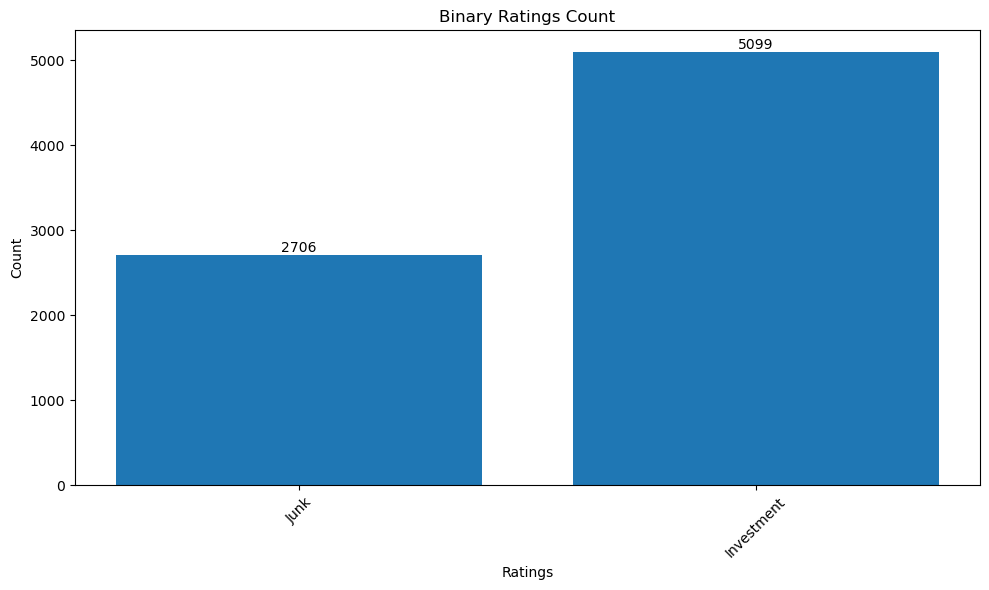

In [67]:
result_df = spark.sql(query).toPandas()

grades = {"0": "Junk", "1": "Investment"}
result_df['Binary_Ratings'] = result_df['Binary_Ratings'].map(grades)

x_labels = result_df['Binary_Ratings']
y_values = result_df['Count']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Binary Ratings Count')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Binary_Ratings.png')
plt.show()

In [70]:
# Create Graph of Counts by Ratings
# Query SparkDF and send to Pandas 
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show(100)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



In [53]:
# Ratings when the Binary Rating = 0
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '0' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show()

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



In [68]:
# Ratings when the Binary Rating = 1
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '1' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show()

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
+------+-----------+



The original dataset for this credit rating project has undergone normalization, aligning all ratings with the S&P ratings, including those from other agencies. Additionally, a Binary Rating has been calculated to adhere to the industry-standard S&P Investment Grades and Junk Grades classification.

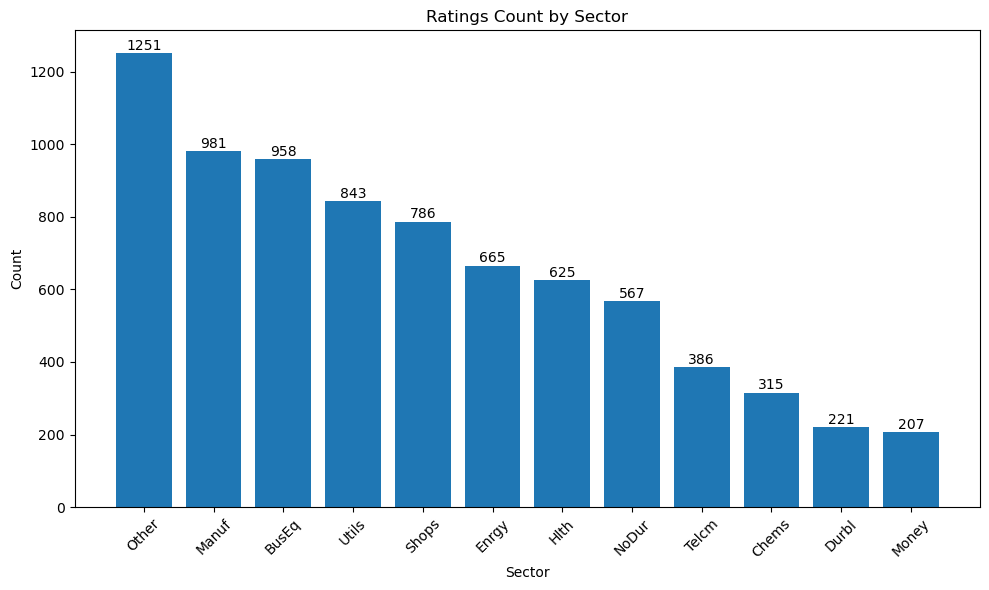

In [52]:
result_df = spark.sql(query).toPandas()

x_labels = result_df['Sector']
y_values = result_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Ratings Count by Sector')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings_by_Sector.png')
plt.show()


In [101]:
# Average Values for "Investment Grade"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '1';
"""
spark.sql(query).show(500)



+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

In [102]:

result = spark.sql(query).collect()
first_row = result[0]
investment_grade_values = list(first_row.asDict().values())


In [103]:
# Average Values for Junk Grade
query2 = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '0';
"""
spark.sql(query).show(500)


+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

In [104]:

result = spark.sql(query2).collect()
first_row = result[0]
junk_grade_values = list(first_row.asDict().values())

In [110]:
metrics = [
    "Current Ratio", "Debt/Capital Ratio", "Debt/Equity Ratio", "Gross Margin",
    "Operating Margin", "EBIT Margin", "EBITDA Margin", "Pre-Tax Profit Margin",
    "Net Profit Margin", "Asset Turnover", "ROE - Return On Equity", "Return On Tangible Equity",
    "ROA - Return On Assets", "ROI - Return On Investment", "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share"]

difference = [i - j for i, j in zip(investment_grade_values, junk_grade_values)]


avg_values_df = pd.DataFrame({
    'Metric': metrics,
    'Investment Grade Avg': investment_grade_values,
    'Junk Grade Avg': junk_grade_values,
    'Difference in Avgs': difference
})

avg_values_df

,Metric,Investment Grade Avg,Junk Grade Avg,Difference in Avgs
0,Current Ratio,1.700042,2.352683,-0.652641
1,Debt/Capital Ratio,0.391542,0.568242,-0.176700
2,Debt/Equity Ratio,0.571551,-0.565460,1.137012
3,Gross Margin,45.044920,37.513898,7.531022
4,Operating Margin,15.263764,4.499001,10.764763
5,EBIT Margin,15.337796,4.506805,10.830992
6,EBITDA Margin,22.878268,14.782602,8.095666
7,Pre-Tax Profit Margin,13.208492,0.088973,13.119519
8,Net Profit Margin,9.631579,-0.855887,10.487466
9,Asset Turnover,0.852060,0.845665,0.006394


In [114]:
query = """
SELECT * FROM ratings
"""
result_df = spark.sql(query).toPandas()
result_df.head()


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.453,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.569,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.462,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [115]:
result_df = result_df.drop(columns=['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK', 'Binary Rating', 'Sector', 'Ticker', 'SIC Code'])
result_df.head()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,1.1507,0.4551,0.8847,77.623,19.4839,19.4839,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.453,1.9957,-0.1333
1,1.1129,0.0072,0.0073,43.6619,19.8327,19.8327,23.9379,20.8699,13.569,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,1.9276,0.2924,0.4255,11.9008,3.3173,3.3173,3.6338,3.0536,2.1418,2.462,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,0.8358,0.4708,0.9491,64.5096,18.4549,18.4549,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,1.2931,0.2644,0.4036,3.8385,1.3269,1.3269,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [127]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Current Ratio                  7805 non-null   object
 1   Long-term Debt / Capital       7805 non-null   object
 2   Debt/Equity Ratio              7805 non-null   object
 3   Gross Margin                   7805 non-null   object
 4   Operating Margin               7805 non-null   object
 5   EBIT Margin                    7805 non-null   object
 6   EBITDA Margin                  7805 non-null   object
 7   Pre-Tax Profit Margin          7805 non-null   object
 8   Net Profit Margin              7805 non-null   object
 9   Asset Turnover                 7805 non-null   object
 10  ROE - Return On Equity         7805 non-null   object
 11  Return On Tangible Equity      7805 non-null   object
 12  ROA - Return On Assets         7805 non-null   object
 13  ROI

In [130]:

result_df = result_df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Current Ratio                  7805 non-null   float64
 1   Long-term Debt / Capital       7805 non-null   float64
 2   Debt/Equity Ratio              7805 non-null   float64
 3   Gross Margin                   7805 non-null   float64
 4   Operating Margin               7805 non-null   float64
 5   EBIT Margin                    7805 non-null   float64
 6   EBITDA Margin                  7805 non-null   float64
 7   Pre-Tax Profit Margin          7805 non-null   float64
 8   Net Profit Margin              7805 non-null   float64
 9   Asset Turnover                 7805 non-null   float64
 10  ROE - Return On Equity         7805 non-null   float64
 11  Return On Tangible Equity      7805 non-null   float64
 12  ROA - Return On Assets         7805 non-null   f

In [143]:
general_aggregations = ['mean', 'std', 'var', 'min', 'max', 'median', 'sum', 'count']

detailed_stats = result_df.agg(general_aggregations)
detailed_stats

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
mean,1.926313,0.452804,0.177349,42.433909,11.531612,11.582683,20.071493,8.659944,5.995566,0.849843,15.950507,21.481589,4.575705,7.076084,0.479756,0.119491
std,1.921651,2.629158,34.456334,23.742020,25.469044,25.483934,24.380407,27.866408,24.055577,0.696204,230.592526,462.734075,9.229899,24.382027,6.050626,7.253660
var,3.692744,6.912471,1187.238958,563.683508,648.672205,649.430894,594.404233,776.536694,578.670780,0.484700,53172.912923,214122.824305,85.191044,594.483227,36.610071,52.615577
min,0.174900,-86.363600,-1473.098000,-87.684000,-461.787800,-461.787800,-360.816900,-476.010000,-414.824800,0.068400,-11258.210000,-14023.260000,-226.442500,-745.454500,-91.330200,-130.665800
max,34.076800,171.500000,194.375000,100.000000,93.993000,93.993000,286.493500,221.289400,219.390300,8.503900,7038.461000,9882.979000,114.716900,466.666700,282.192100,107.737700
median,1.496800,0.427200,0.752800,39.635400,12.120100,12.155800,18.304500,9.705100,6.938900,0.661200,12.500000,10.564100,4.767500,7.440800,0.237800,0.133500
sum,15034.872600,3534.132900,1384.205700,331196.658400,90004.232200,90402.837800,156658.006300,67590.864000,46795.389700,6633.023200,124493.705000,167663.800700,35713.380300,55228.837700,3744.495400,932.625900
count,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000


24/03/20 14:26:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 927650 ms exceeds timeout 120000 ms
24/03/20 14:26:59 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/20 14:27:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

To facilitate further analysis, the data will be saved to a database for efficient storage and retrieval. Additionally, Pandas will be employed for detailed exploration and manipulation of the dataset, enabling comprehensive analysis and insights generation.

In [144]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

# Import CSV into database
df = pd.read_csv('../data/ratings.csv')
conn.close()


In [145]:
df.head()

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [146]:
df.columns

Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

## Graphing Distribution and Outliers

In [149]:
# Creating filters for Junk Grade and Investment Grade
df_rating_0 = df[df['Binary Rating'] == 0]
df_rating_1 = df[df['Binary Rating'] == 1]



In [150]:
# Function will show a box plot comparing the distribution of poor credit and good credit among various features. It will also show a distribution of the feature for both good and poor credit. 

def visualize_data(t, df_rating_0, df_rating_1, df):
    # Box plot
    plt.figure(figsize=(8, 6)) 
    box = plt.boxplot([df_rating_0[t], df_rating_1[t]],
                 notch=True, vert=True, patch_artist=True, labels=['Junk Grade', 'Investment Grade'])

    # Set colors for each box
    colors = ['firebrick', 'royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    plt.xlabel('Credit Ratings')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {t} by Binary Ratings')
    plt.grid(True)
    # t2 removes slashes and spaces from the column name when using to save the charts
    t2 = re.sub(r'[ /]', '_', t)
    plt.savefig(f'../img/features/{t2}_box.png')
    plt.show()

    # Histogram
    plt.hist(df[t], color='darkseagreen')

    plt.xlabel("Amount")
    plt.ylabel('Frequency')
    plt.title(f'Total Distribution of {t}')
    plt.savefig(f'../img/features/{t2}_hist.png')
    plt.show()
    print(df[t].describe())


Processing column: Current Ratio


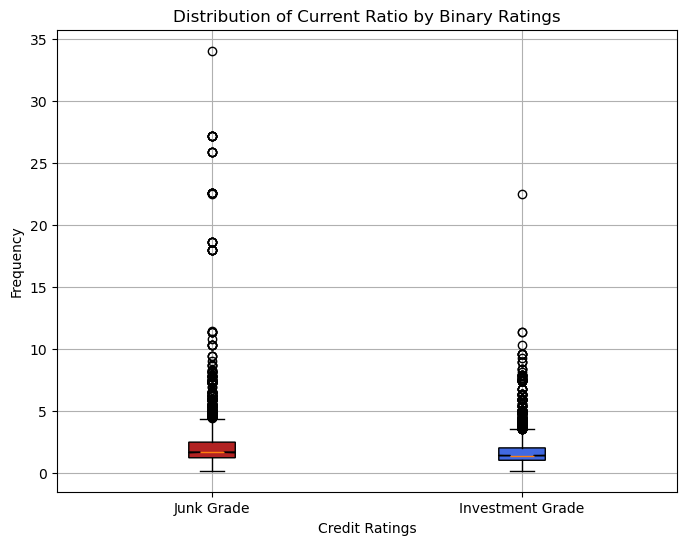

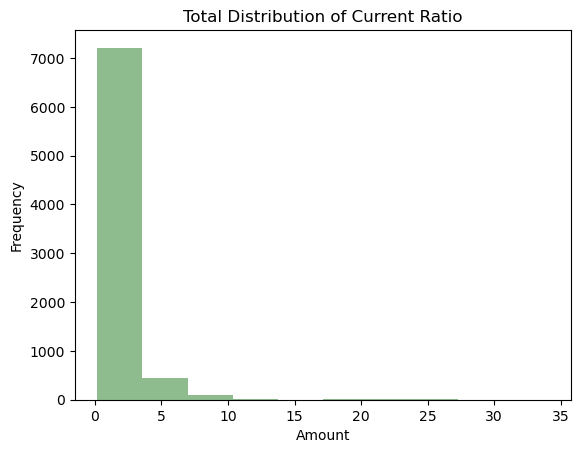

count    7805.000000
mean        1.926313
std         1.921651
min         0.174900
25%         1.077300
50%         1.496800
75%         2.161000
max        34.076800
Name: Current Ratio, dtype: float64
Processing column: Long-term Debt / Capital


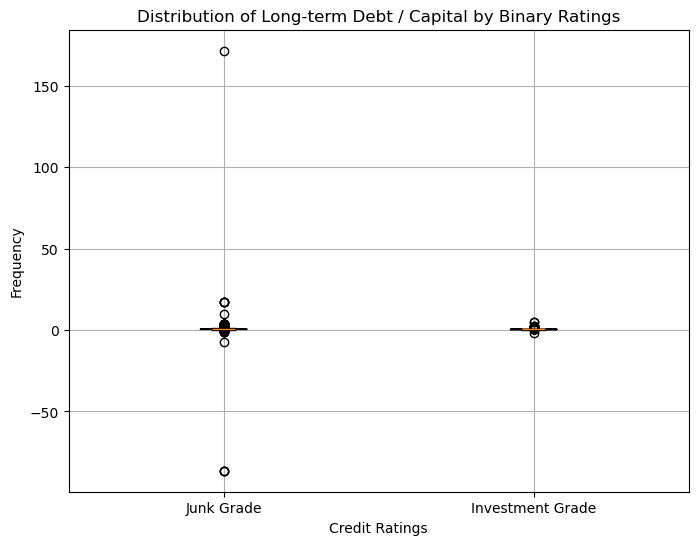

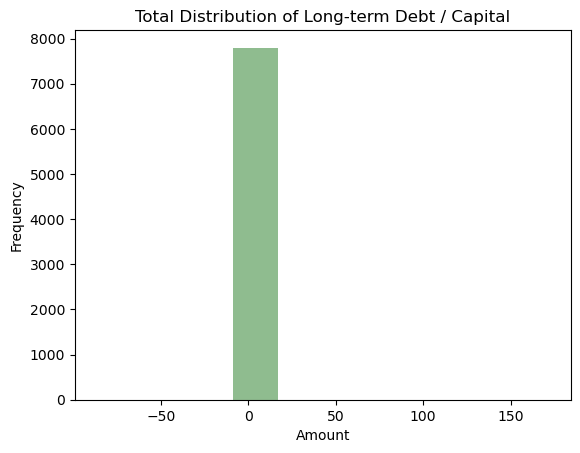

count    7805.000000
mean        0.452804
std         2.629158
min       -86.363600
25%         0.286500
50%         0.427200
75%         0.542200
max       171.500000
Name: Long-term Debt / Capital, dtype: float64
Processing column: Debt/Equity Ratio


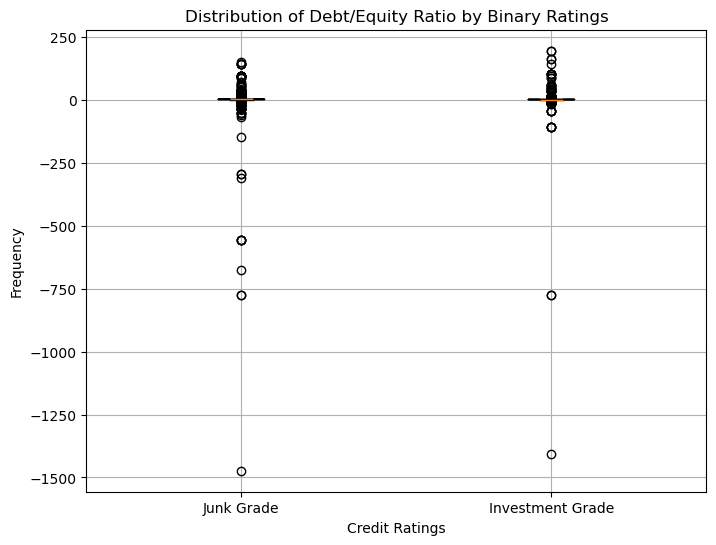

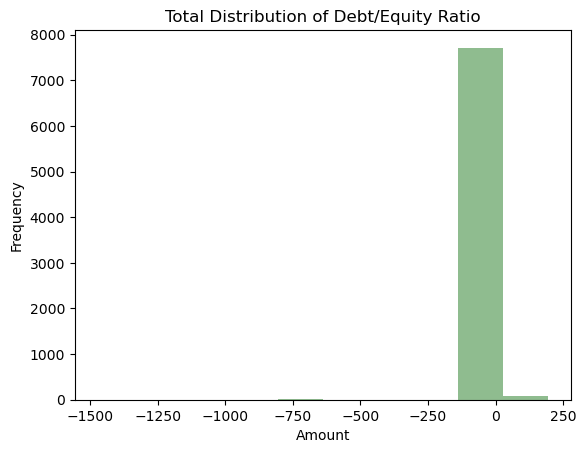

count    7805.000000
mean        0.177349
std        34.456334
min     -1473.098000
25%         0.419700
50%         0.752800
75%         1.211600
max       194.375000
Name: Debt/Equity Ratio, dtype: float64
Processing column: Gross Margin


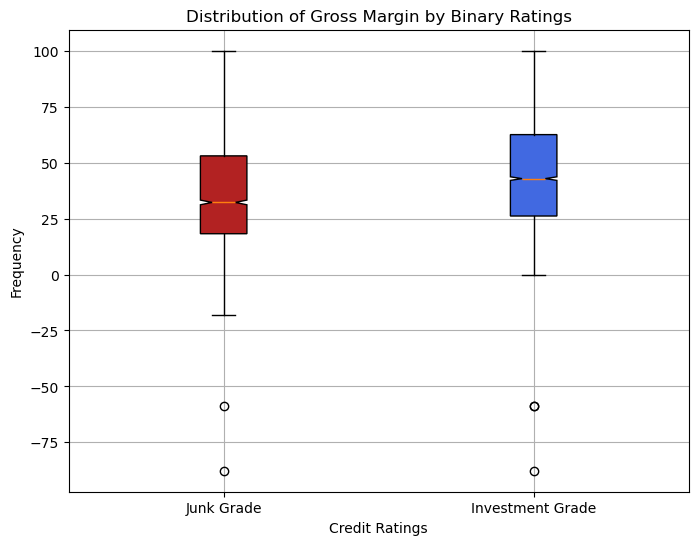

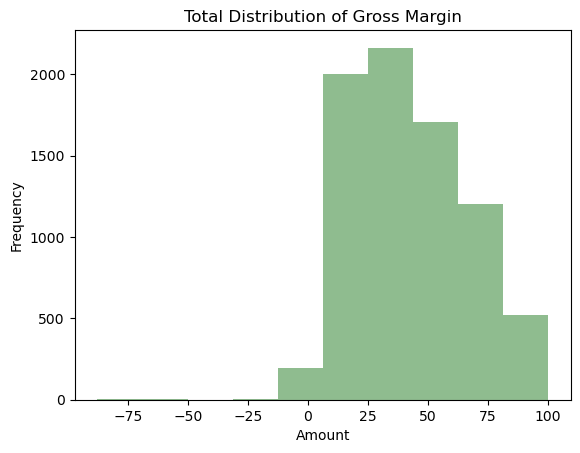

count    7805.000000
mean       42.433909
std        23.742020
min       -87.684000
25%        22.453900
50%        39.635400
75%        59.641700
max       100.000000
Name: Gross Margin, dtype: float64
Processing column: Operating Margin


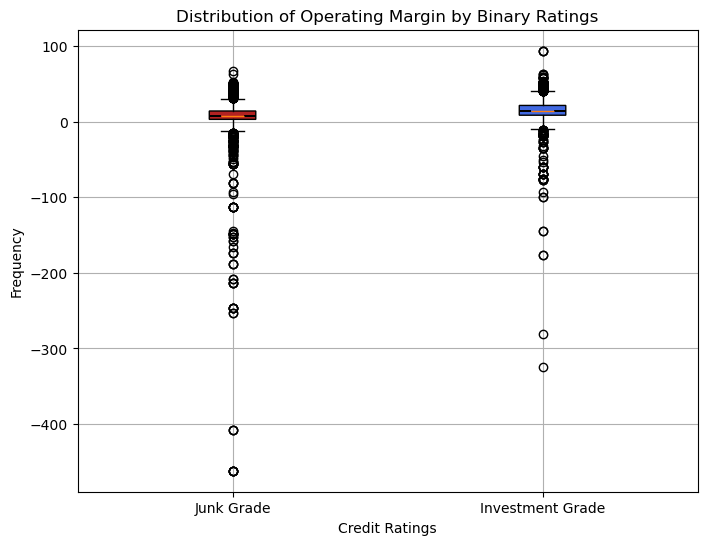

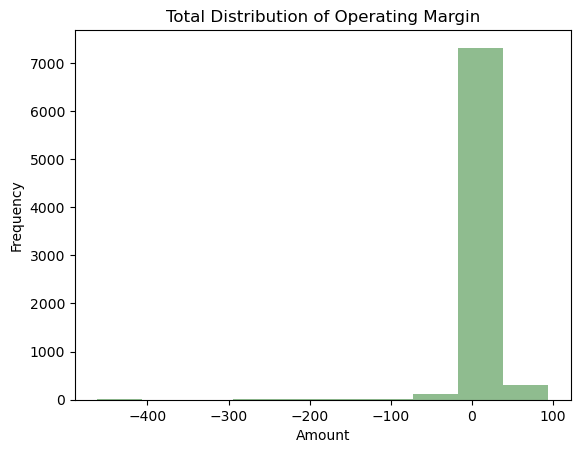

count    7805.000000
mean       11.531612
std        25.469044
min      -461.787800
25%         6.098200
50%        12.120100
75%        19.464600
max        93.993000
Name: Operating Margin, dtype: float64
Processing column: EBIT Margin


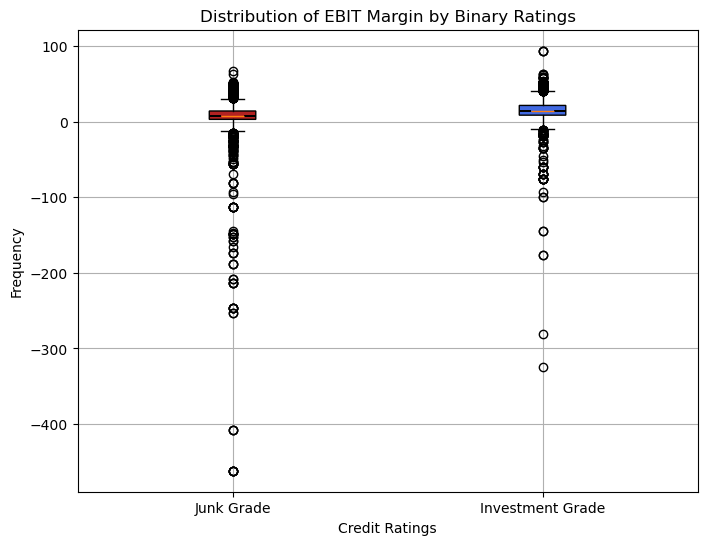

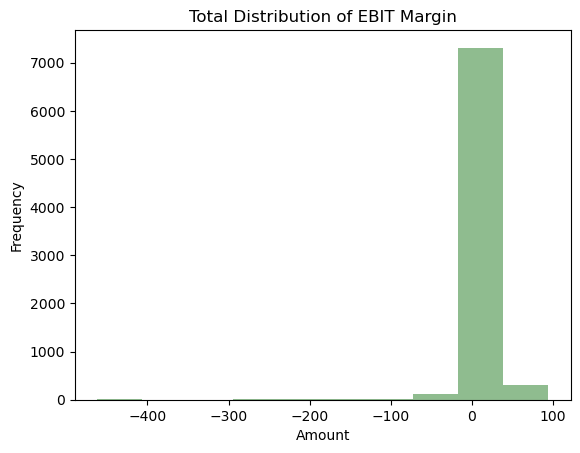

count    7805.000000
mean       11.582683
std        25.483934
min      -461.787800
25%         6.181100
50%        12.155800
75%        19.539900
max        93.993000
Name: EBIT Margin, dtype: float64
Processing column: EBITDA Margin


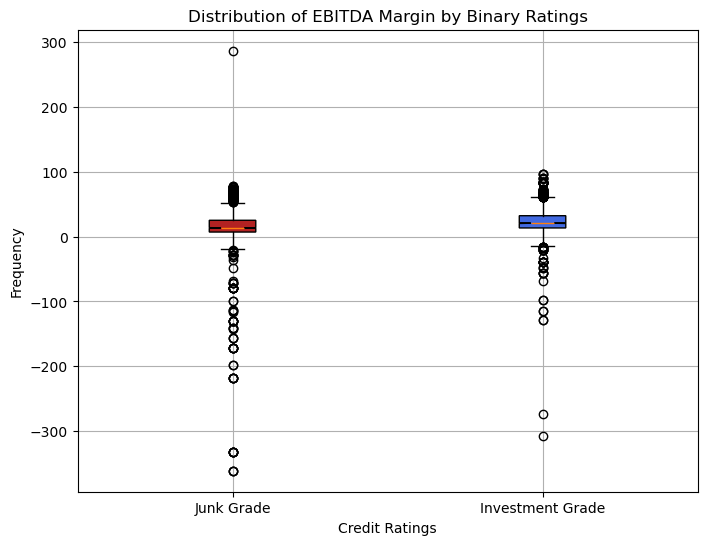

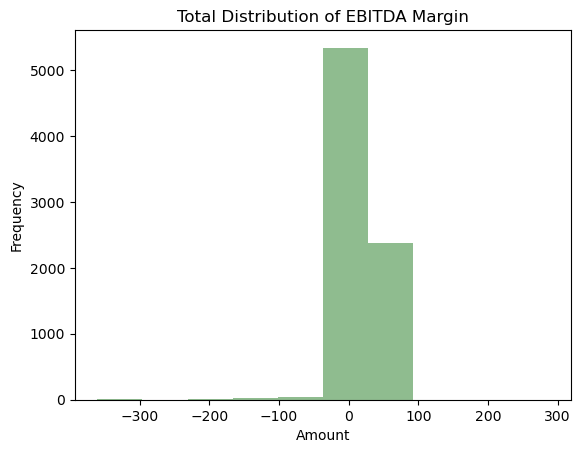

count    7805.000000
mean       20.071493
std        24.380407
min      -360.816900
25%        11.162100
50%        18.304500
75%        30.661600
max       286.493500
Name: EBITDA Margin, dtype: float64
Processing column: Pre-Tax Profit Margin


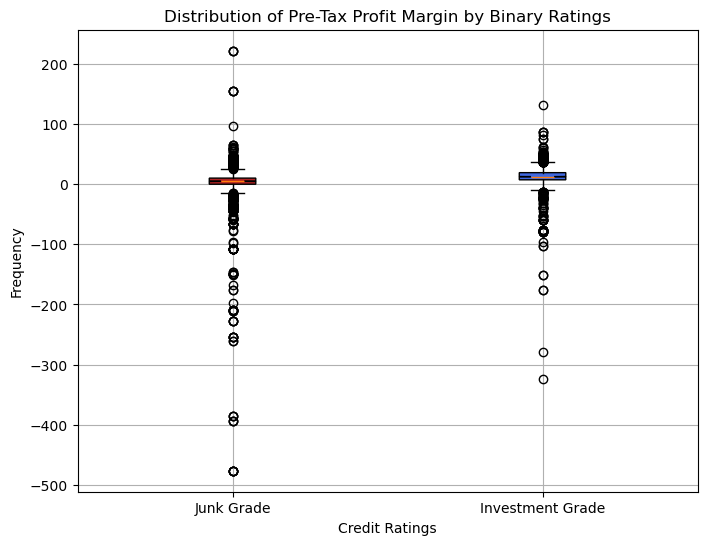

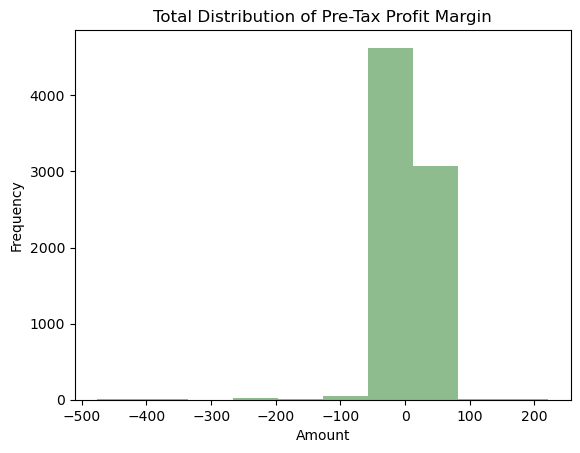

count    7805.000000
mean        8.659944
std        27.866408
min      -476.010000
25%         4.008700
50%         9.705100
75%        16.676900
max       221.289400
Name: Pre-Tax Profit Margin, dtype: float64
Processing column: Net Profit Margin


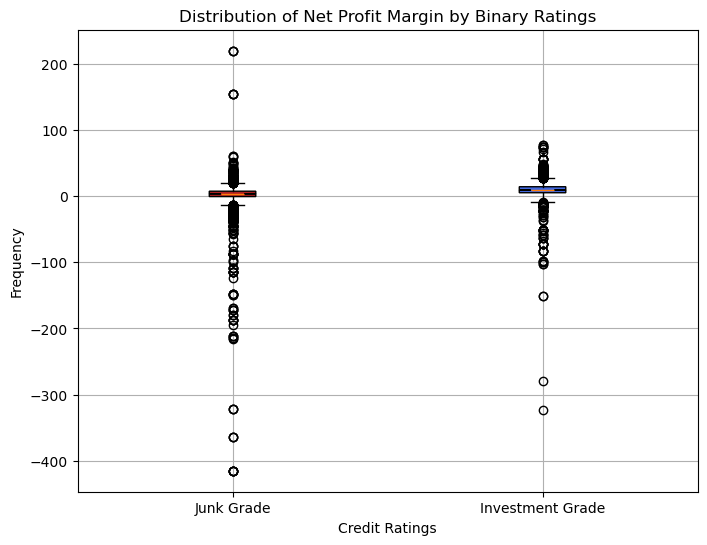

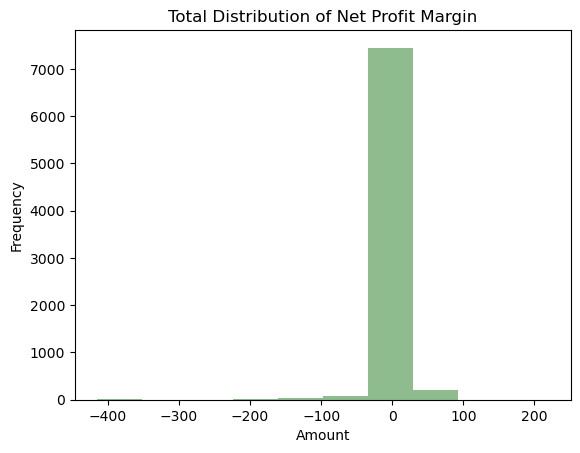

count    7805.000000
mean        5.995566
std        24.055577
min      -414.824800
25%         2.637100
50%         6.938900
75%        12.366700
max       219.390300
Name: Net Profit Margin, dtype: float64
Processing column: Asset Turnover


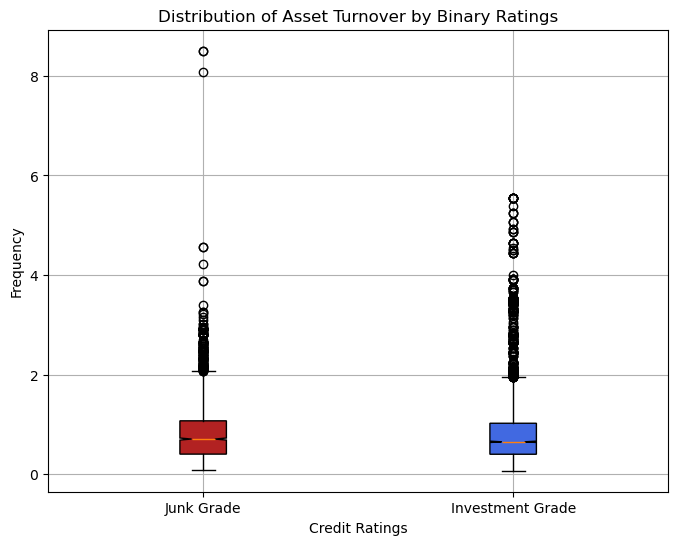

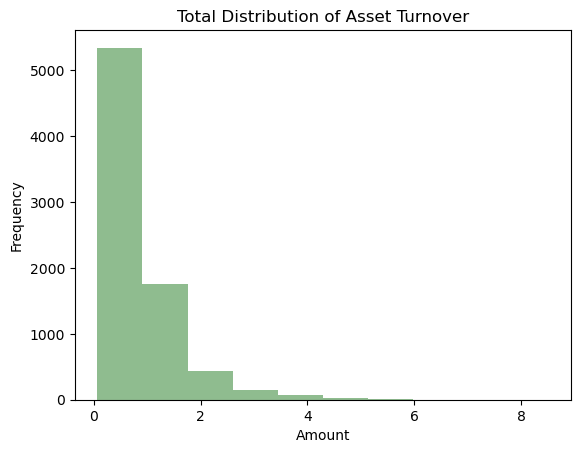

count    7805.000000
mean        0.849843
std         0.696204
min         0.068400
25%         0.399500
50%         0.661200
75%         1.038800
max         8.503900
Name: Asset Turnover, dtype: float64
Processing column: ROE - Return On Equity


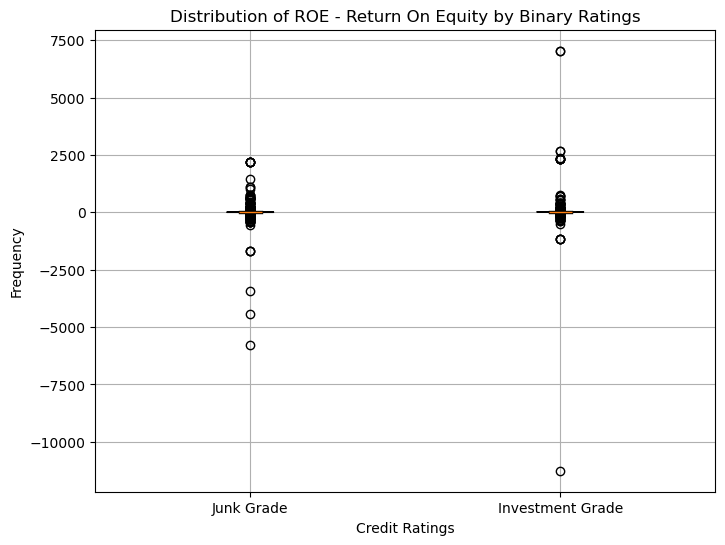

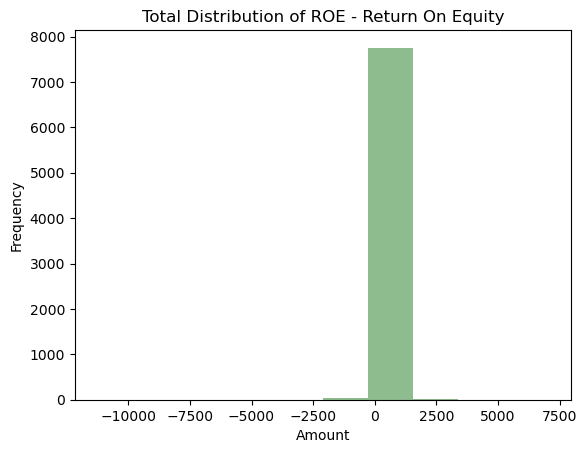

count     7805.000000
mean        15.950507
std        230.592526
min     -11258.210000
25%          6.022800
50%         12.500000
75%         20.515700
max       7038.461000
Name: ROE - Return On Equity, dtype: float64
Processing column: Return On Tangible Equity


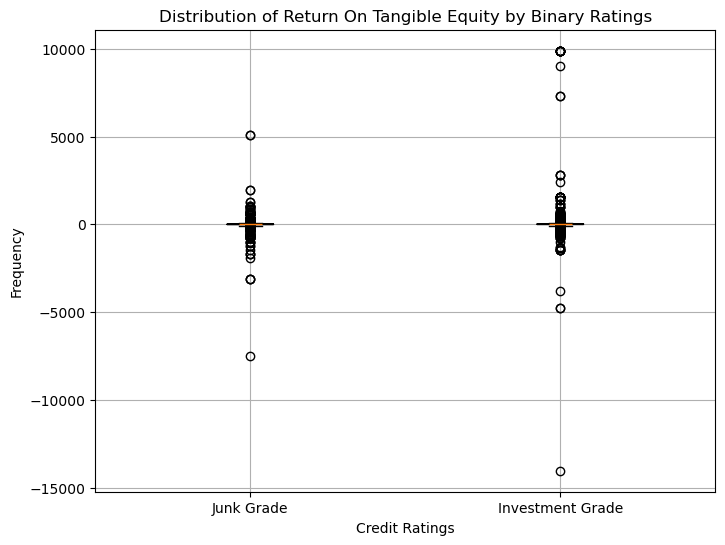

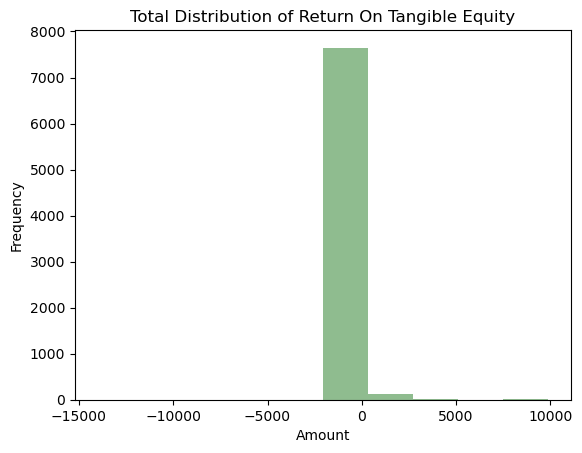

count     7805.000000
mean        21.481589
std        462.734075
min     -14023.260000
25%        -12.233900
50%         10.564100
75%         26.894100
max       9882.979000
Name: Return On Tangible Equity, dtype: float64
Processing column: ROA - Return On Assets


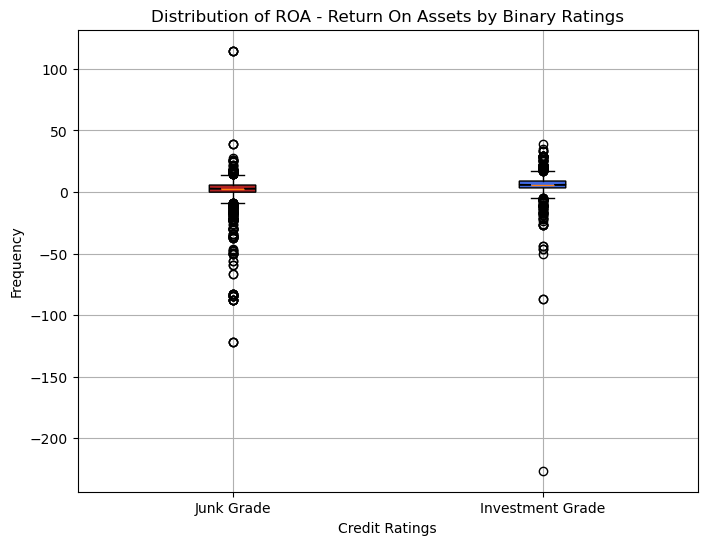

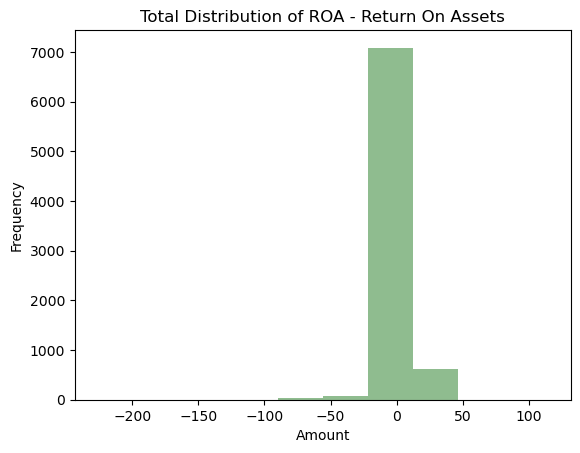

count    7805.000000
mean        4.575705
std         9.229899
min      -226.442500
25%         2.391900
50%         4.767500
75%         7.881300
max       114.716900
Name: ROA - Return On Assets, dtype: float64
Processing column: ROI - Return On Investment


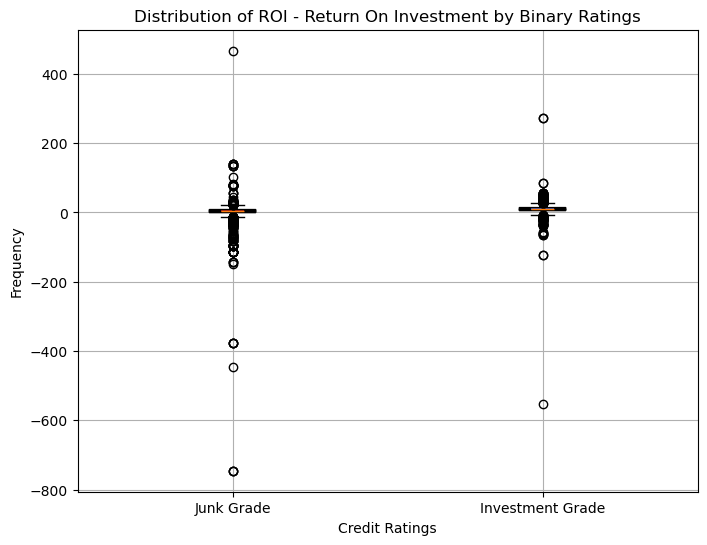

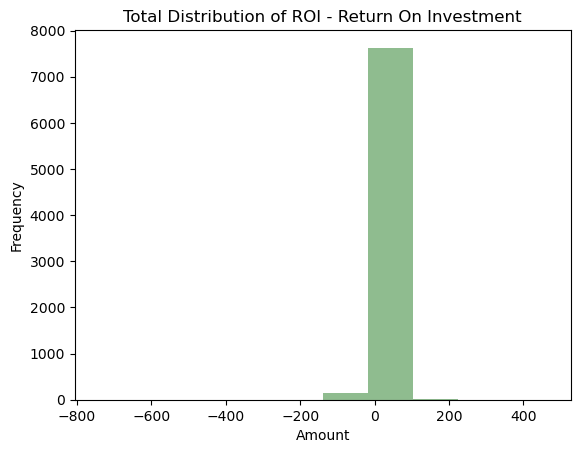

count    7805.000000
mean        7.076084
std        24.382027
min      -745.454500
25%         3.692600
50%         7.440800
75%        12.515100
max       466.666700
Name: ROI - Return On Investment, dtype: float64
Processing column: Operating Cash Flow Per Share


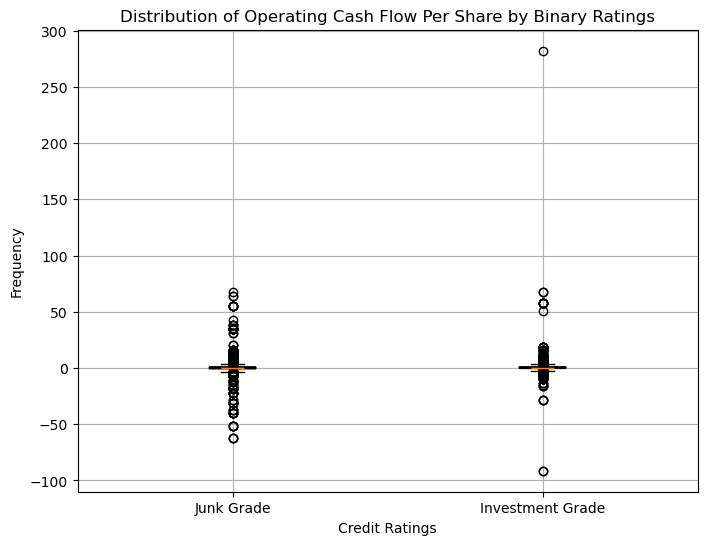

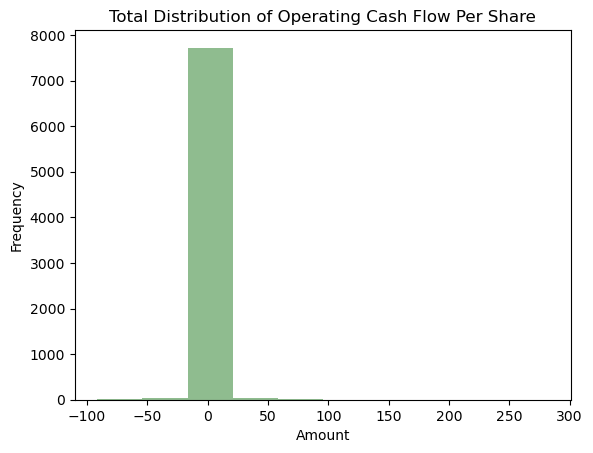

count    7805.000000
mean        0.479756
std         6.050626
min       -91.330200
25%        -0.448500
50%         0.237800
75%         1.088800
max       282.192100
Name: Operating Cash Flow Per Share, dtype: float64
Processing column: Free Cash Flow Per Share


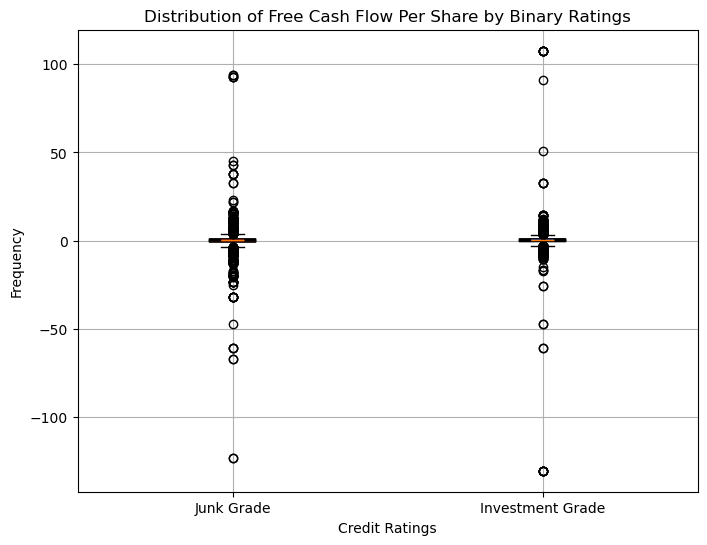

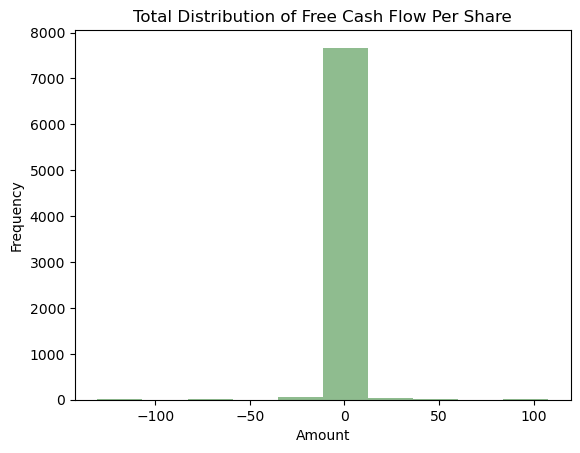

count    7805.000000
mean        0.119491
std         7.253660
min      -130.665800
25%        -0.723700
50%         0.133500
75%         0.997800
max       107.737700
Name: Free Cash Flow Per Share, dtype: float64


In [151]:
col_list = ['Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

for t in col_list:
    print(f"Processing column: {t}")
    visualize_data(t, df_rating_0, df_rating_1, df)

In [152]:

def sector_chart(sector):
    filtered_df_1 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()

    plt.bar(['Junk Rating', 'Investment Rating'], [ratingCount0, ratingCount1], color=['firebrick', 'royalblue'])
    plt.xlabel('Credit Rating')
    plt.ylabel('Count')
    plt.title(f'Counts of Credit Ratings in the {sector} Sector')
    plt.savefig(f'../img/sectors/{sector}_bar.png')
    plt.show()

Processing sector: Utils


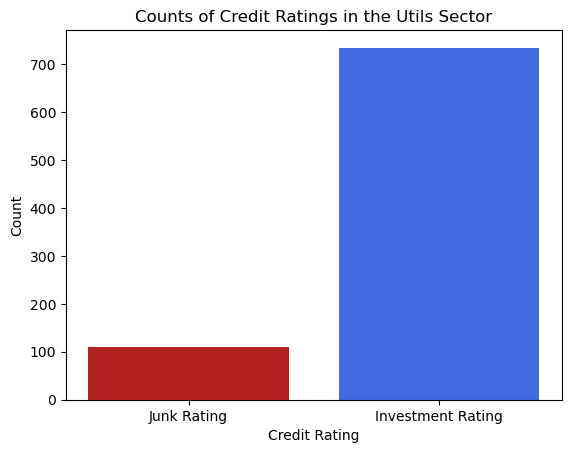

Processing sector: BusEq


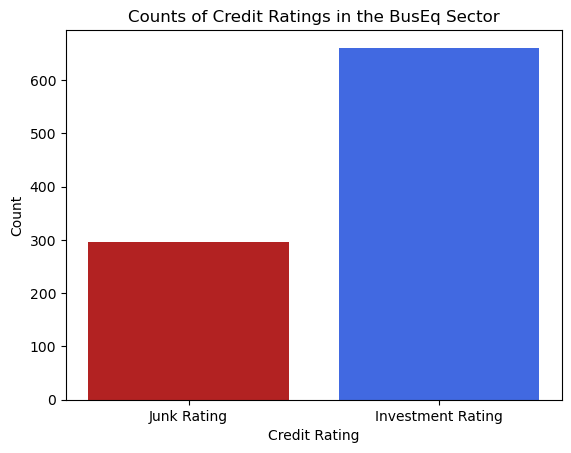

Processing sector: Shops


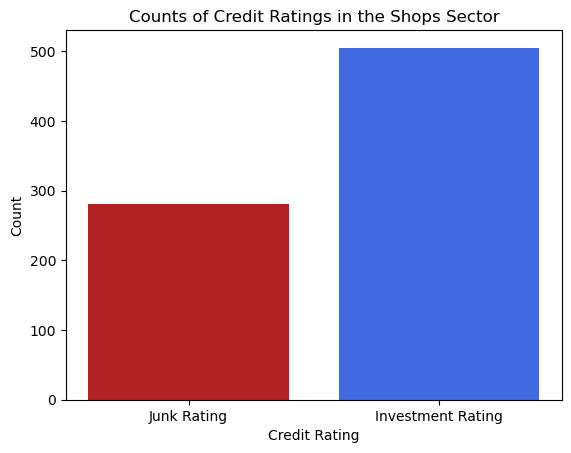

Processing sector: Manuf


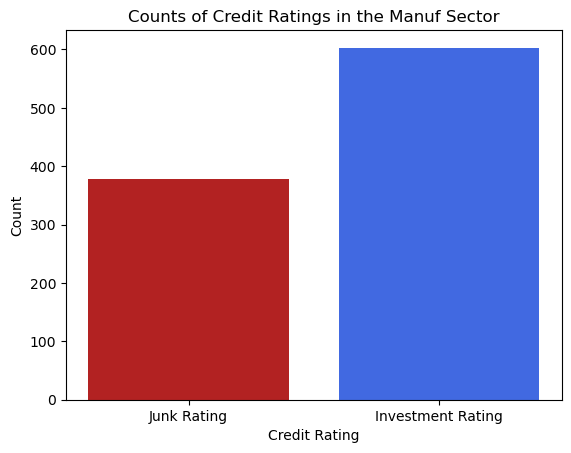

Processing sector: NoDur


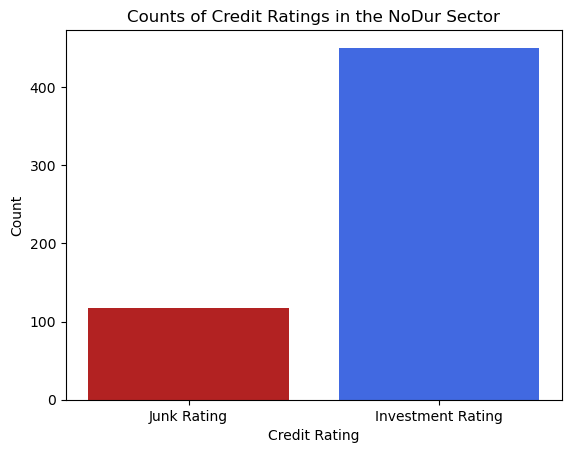

Processing sector: Other


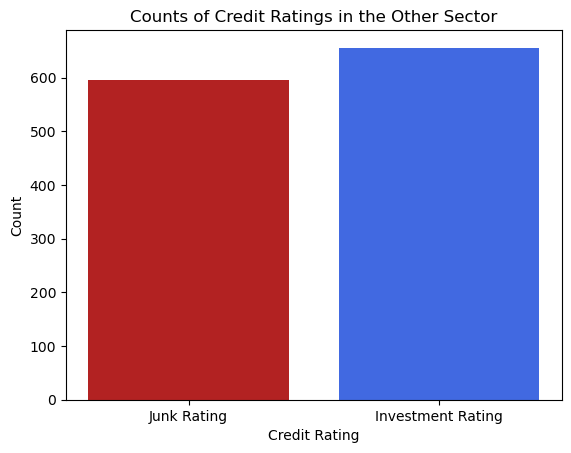

Processing sector: Chems


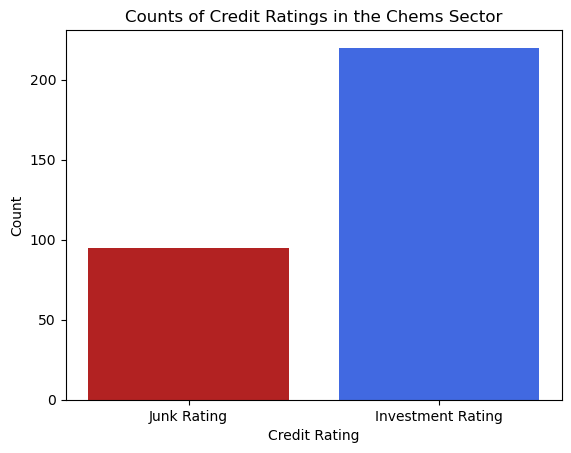

Processing sector: Telcm


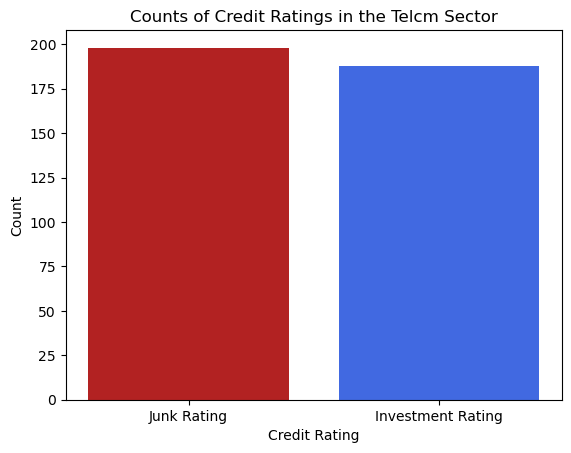

Processing sector: Hlth


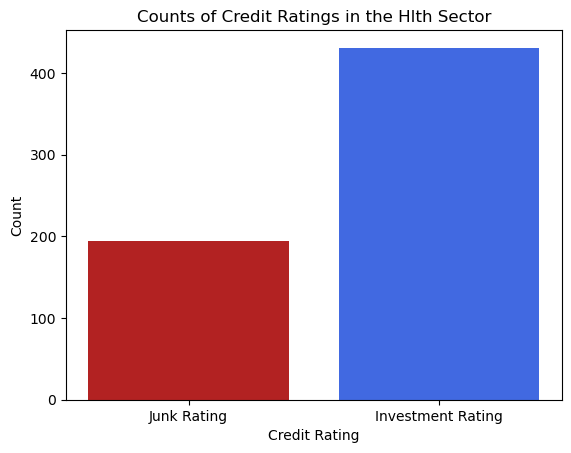

Processing sector: Money


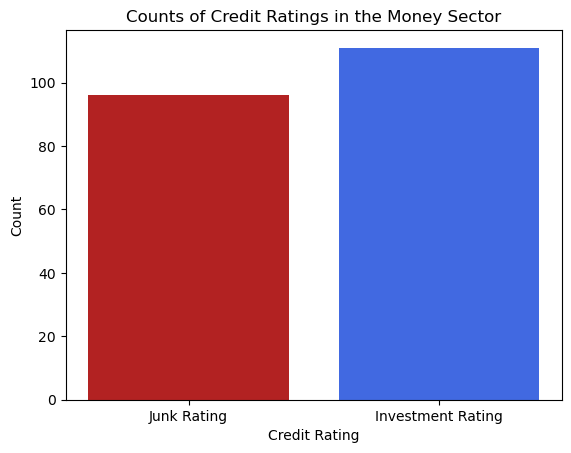

Processing sector: Durbl


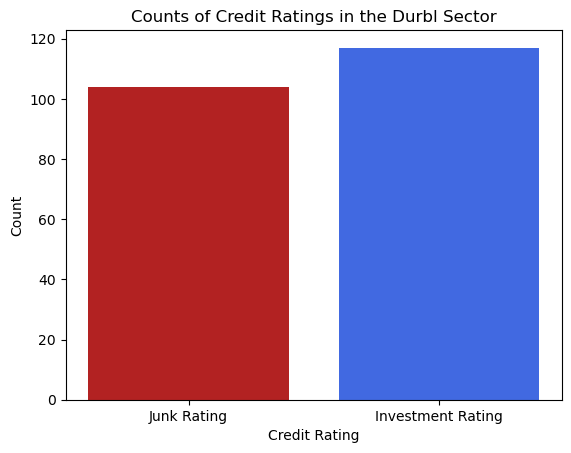

Processing sector: Enrgy


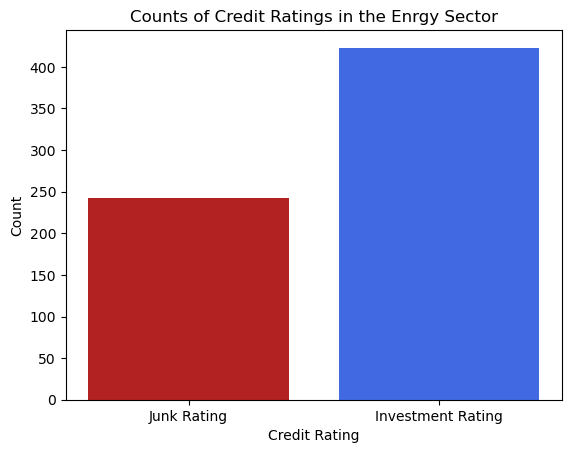

In [153]:
for sector in df['Sector'].unique():
    print(f"Processing sector: {sector}")
    sector_chart(sector)

In conclusion, our analysis has revealed the presence of a significant number of outliers within the dataset.

To enhance the data preprocessing phase, it is advisable to transform certain categorical features from string representations into numeric formats.

In [154]:
# Sector information appears useful so converting to numeric data
secDict = {"Other": 1, "Manuf": 2, "BusEq": 3, "Utils": 4, "Shops": 5, "Enrgy": 6, "Hlth": 7, "NoDur": 8, "Telcm": 9, "Chems": 10, "Durbl": 11, "Money": 12}
df['Sector'] = df['Sector'].replace(secDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
1507,Moody's Investors Service,Alere Inc.,CCC+,2013-05-13,1145460,0,2835.0,7,ALR,0.7868,...,3.9090,1.4383,1.8469,2.0300,3.4013,3.7335,1.7799,3.0346,0.1419,0.5621
1899,Moody's Investors Service,Eastman Kodak Company,B+,2013-07-16,31235,0,3577.0,3,KODK,0.7791,...,-14.6010,-59.2130,-50.7172,0.6293,36.3612,34.5478,-30.9419,45.5226,2.7457,3.2976
3115,Fitch Ratings,"BorgWarner, Inc.",BBB+,2014-04-15,908255,1,3714.0,11,BWA,1.7233,...,15.5259,11.6895,8.3950,1.0751,17.9220,26.7307,9.4116,13.9898,-0.5125,-0.6404
2386,Egan-Jones Ratings Company,PINNACLE WEST CAPITAL,A+,2013-11-18,764622,1,4911.0,4,PNW,0.9282,...,36.8375,19.8773,11.5556,0.2468,10.2136,10.2136,3.1316,5.7385,0.3506,0.4563
799,Moody's Investors Service,"Great Atlantic & Pacific Tea Co., Inc.(The)",B-,2012-06-15,43300,0,5411.0,5,GAP,2.0249,...,13.3617,9.4096,5.7255,1.9603,30.2359,30.2359,11.2234,19.1011,-0.1635,-0.3227
3279,Standard & Poor's Ratings Services,Cementos Pacasmayo S.A.A.,BB+,2014-02-14,1221029,0,3241.0,2,CPAC,4.7478,...,23.8074,19.6031,13.3011,0.4908,8.3950,8.3948,6.6716,7.6201,0.2341,-0.3968
6821,Standard & Poor's Ratings Services,Yum! Brands Inc.,BB,2015-12-10,1041061,0,5812.0,5,YUM,0.7466,...,19.2525,11.8542,8.3384,1.5048,47.7344,151.5669,12.2369,20.6722,-0.2100,-0.1620
4096,Fitch Ratings,"Nabors Industries, Inc.",BBB+,2014-06-23,1163739,1,1381.0,6,NBR,2.7666,...,24.0786,4.1853,2.4908,0.5229,3.9109,4.2476,1.8408,2.2539,18.3050,107.7377
1707,Standard & Poor's Ratings Services,California Water Service Co.,A-,2013-05-06,1035201,1,4941.0,4,CWT,0.6030,...,26.9966,12.5508,8.7198,0.2806,10.3075,10.3648,2.4464,5.3765,0.4851,0.2757
2225,Fitch Ratings,Meritage Homes Corporation,BB-,2013-11-22,833079,0,1531.0,1,MTH,1.5391,...,6.1645,2.4157,8.8043,0.7581,15.1486,15.7495,6.6746,7.4215,-3.9918,-4.0677


In [158]:
def agency_Chart(agency, a2):
    filtered_df_1 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()
    
    plt.bar(['Junk Grade', 'Investment Grade'], [ratingCount0, ratingCount1], color=['firebrick', 'royalblue'])
    plt.xlabel('Credit Rating')
    plt.ylabel('Count')
    plt.title(f'Counts of {agency} by Ratings')

    plt.savefig(f'../img/agencies/{a2}_bar.png')
    plt.show()

Processing agency: Standard & Poor's Ratings Services
a2: StandardPoorsRatingsServices


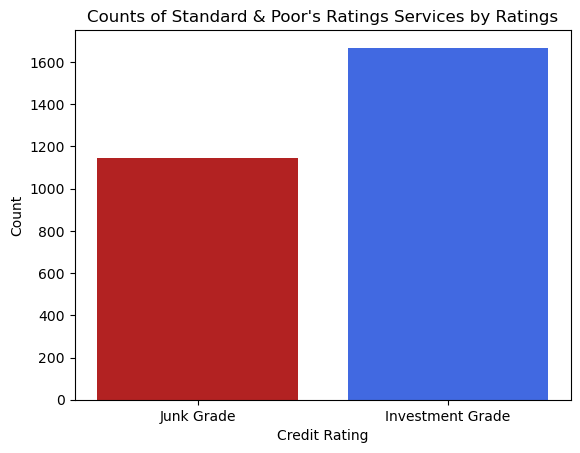

Processing agency: DBRS
a2: DBRS


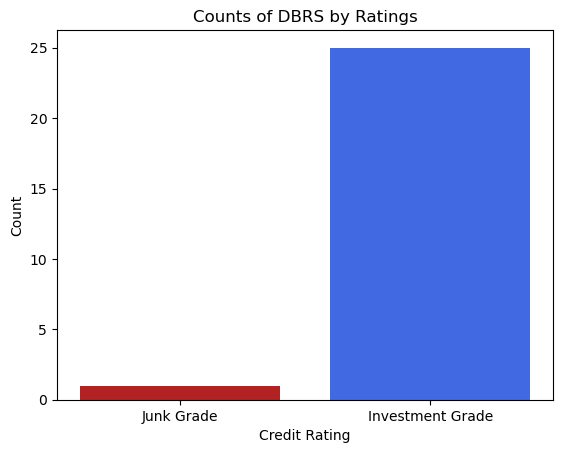

Processing agency: Moody's Investors Service
a2: MoodysInvestorsService


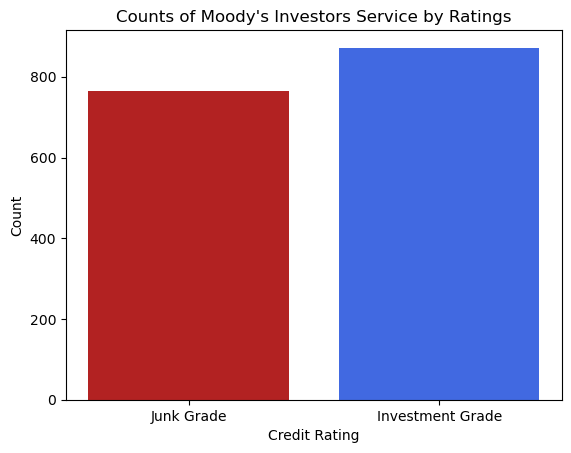

Processing agency: Fitch Ratings
a2: FitchRatings


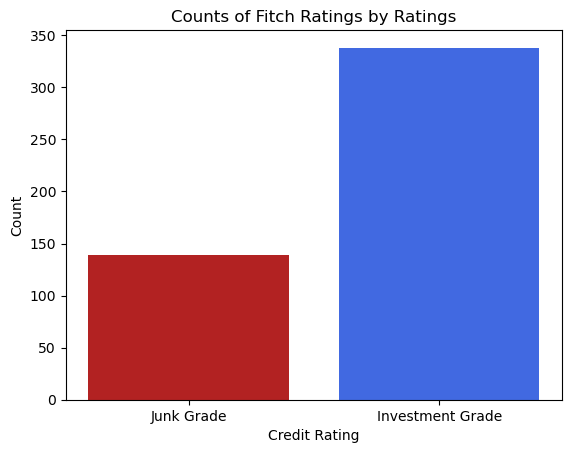

Processing agency: Japan Credit Rating Agency,Ltd.
a2: JapanCreditRatingAgencyLtd


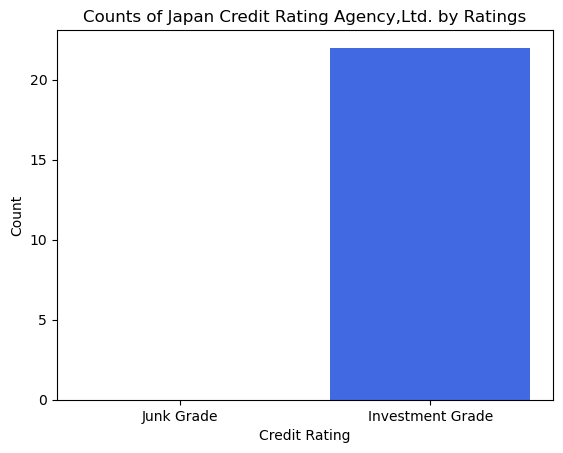

Processing agency: HR Ratings de Mexico S.A. de C.V.
a2: HRRatingsdeMexicoSAdeCV


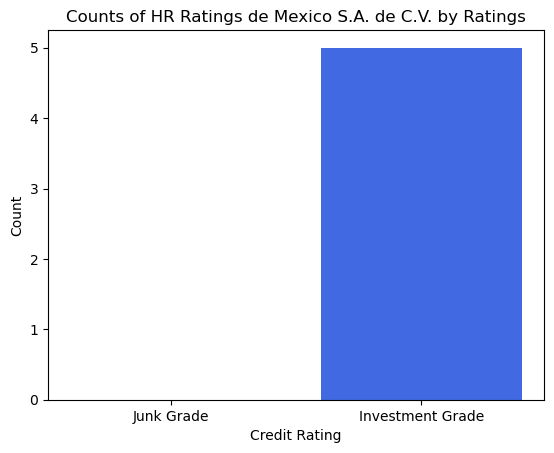

Processing agency: Egan-Jones Ratings Company
a2: EganJonesRatingsCompany


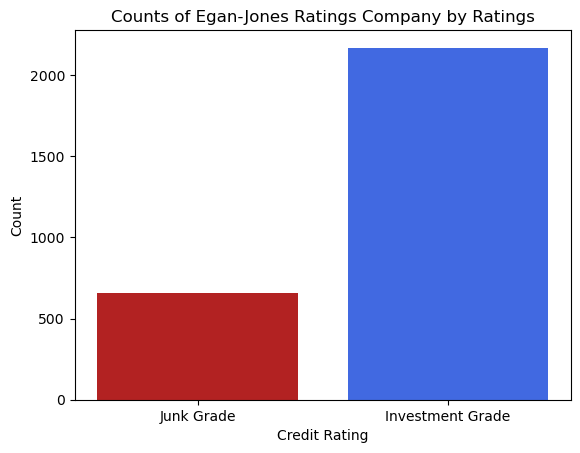

In [159]:
for agency in df['Rating Agency'].unique():
    a2 = re.sub(r'[^\w]', '', agency)
    print(f"Processing agency: {agency}")
    print(f'a2: {a2}')

    agency_Chart(agency, a2)

In [160]:
agency_counts = df['Rating Agency'].value_counts()

# Create a dictionary with incremental numeric values
agencyDict = {}
count = 1
for agency in agency_counts.index:
    agencyDict[agency] = count
    count += 1

df['Rating Agency'] = df['Rating Agency'].replace(agencyDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
3680,1,HESS CORPORATION,A-,2014-01-30,4447,1,1311.0,6,HES,1.0006,...,48.4443,27.2519,16.5374,0.2819,8.5271,9.5183,4.1620,6.3379,1.9693,0.8514
5169,1,"CISCO SYSTEMS, INC",AA,2015-09-24,858877,1,3576.0,3,CSCO,3.1338,...,26.8750,22.7843,18.2686,0.4336,15.0418,27.3294,7.9216,11.0653,0.1040,0.0673
3194,1,COCA-COLA EUROPEAN PARTNERS,A-,2014-07-30,1650107,1,2086.0,8,CCEP,1.0710,...,15.6661,10.3820,8.3974,0.8477,25.1393,-49.7063,7.1188,12.2490,0.5101,0.4351
4824,1,AMERICA MOVIL SAB DE CV,BBB,2015-10-26,1129137,1,4812.0,9,AMX,0.7611,...,32.0135,10.2820,5.4394,0.6636,20.2409,-295.2425,3.7153,6.0844,1.3086,1.0362
1274,3,Southern Power Company,BBB-,2012-12-10,1001838,1,1000.0,1,SCCO,3.1075,...,57.3944,50.5768,34.2648,0.8457,58.0820,59.7159,29.0765,34.6183,0.1976,-0.0391
6537,1,TENNECO INC,A-,2015-10-29,1024725,1,3714.0,11,TEN,1.3485,...,8.3967,4.7625,2.6841,2.1071,50.1859,60.4027,6.7568,16.9492,-2.6471,-4.1244
821,2,Harley-Davidson Inc.,BBB+,2012-01-25,793952,1,3751.0,11,HOG,2.0194,...,18.9870,8.0354,3.0157,0.5153,11.7664,11.9263,2.7534,3.8598,2.3478,2.1200
6853,2,Alere Inc.,B,2016-06-06,1145460,0,2835.0,7,ALR,0.4594,...,1.6211,-2.9381,-3.1553,2.5677,-22.0974,-22.0974,-7.6648,-16.6467,3.7242,1.2751
3558,1,FLUOR CORPORATION,A+,2014-11-25,1124198,1,1600.0,1,FLR,1.7621,...,5.2650,4.3054,2.4412,3.2859,21.2075,21.8500,9.8876,18.8016,1.2166,0.8161
6885,2,Amgen Inc.,A,2016-02-23,318154,1,2836.0,7,AMGN,4.4454,...,48.8321,36.8295,32.0331,0.3032,24.7089,419.2749,9.7118,12.1174,1.0777,1.5885


Column Drop and Dummy Variables Addition

In [ ]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

reduced_df = df.drop(columns=['Corporation', 'Rating', 'CIK', 'Ticker', 'SIC Code', 'Rating Date'])
dummies = pd.get_dummies(reduced_df.dropna(axis=1))  

df.to_sql('ratings', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
reduced_df.to_sql('clean', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
dummies.to_sql('dummies', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})

conn.close()